# Bharathwaj  Murali  19BAI1137
# Kavin A.K  19BAI1102

# Information Security Analysis and Audit(CSE3501)


#Intrusion Detection using RNN-LSTM



#   Binary Classification(Attack or Normal) using KDDTest+ for testing the models



In [1]:
# import libraries
import pandas as pd
import numpy as np
import sys
import sklearn
import io
import random

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
## add the columns' name and read the KDDTrain+ and KDDTest+ datasets
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

#training set
df = pd.read_csv("/content/gdrive/MyDrive/cyber datasets/nsl/NSL_KDD_Train.csv",header=None, names = col_names)
#testing set
df_test = pd.read_csv("/content/gdrive/MyDrive/cyber datasets/nsl/NSL_KDD_Test.csv", header=None, names = col_names)

print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape)

Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)


In [4]:
print('Label distribution in the Training set:')
print("****************************************")
print(df['label'].value_counts())

Label distribution in the Training set:
****************************************
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64


In [5]:
print('Label distribution in the Test set:')
print("**************************************")
print(df_test['label'].value_counts())

Label distribution in the Test set:
**************************************
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
rootkit              13
xterm                13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
perl                  2
udpstorm              2
sqlattack             2
phf                   2
loadmodule            2
worm                  2
imap                  1
Name: label, 

# **Step 1: Data preprocessing:**



In [6]:
# columns are categorical, not yet binary: protocol_type (column 2), service (column 3), flag (column 4).

print('Training set:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

print()
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [ ]:
# Test set
print('Test set:')
for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


**LabelEncoder**

**Insert categorical features into a 2D numpy array**

In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_columns=['protocol_type', 'service', 'flag']

df_categorical_values = df[categorical_columns]
testdf_categorical_values = df_test[categorical_columns]

df_categorical_values.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


In [ ]:
# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
print(unique_protocol2)

# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
print(unique_service2)


# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
print(unique_flag2)


# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2


#do it for test set
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2


['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp']
['service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'ser

**Transform categorical features into numbers using LabelEncoder()**

In [ ]:
# train set
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print(df_categorical_values.head())
print('--------------------')
print(df_categorical_values_enc.head())
# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

  protocol_type   service flag
0           tcp  ftp_data   SF
1           udp     other   SF
2           tcp   private   S0
3           tcp      http   SF
4           tcp      http   SF
--------------------
   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


**One-Hot-Encoding**

In [ ]:
# train set
enc = OneHotEncoder(categories='auto')
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

Missing columns in test set are added 




In [ ]:
trainservice=df['service'].tolist()
testservice= df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]

for col in difference:
    testdf_cat_data[col] = 0

print(df_cat_data.shape)    
print(testdf_cat_data.shape)

(125973, 84)
(22544, 84)


New numeric columns are added to main dataframe

In [ ]:
newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)

# test data
newdf_test=df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)

print(newdf.shape)
print(newdf_test.shape)

(125973, 123)
(22544, 123)


In [ ]:
# Convert the "label" catagorical values into numerical values

labeldf=newdf['label']
labeldf_test=newdf_test['label']

# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})



In [ ]:
# put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test

In [ ]:
#Convert "label" into normal=0 and attack=1 for KDDTrain+
newdf['class']=newdf['label'].apply(lambda x: 1 if x>=1 else 0)
newdf.drop(['label'], axis=1)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Protocol_type_icmp,Protocol_type_tcp,...,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,class
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,25,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
125969,8,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
125970,0,2231,384,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
125971,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,8,1.0,1.0,0.0,0.0,0.06,0.05,0.00,255,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,

In [ ]:
#Convert "label" into normal=0 and attack=1 for KDDTest+
newdf_test['class']=newdf_test['label'].apply(lambda x: 1 if x>=1 else 0)
newdf_test.drop(['label'],1)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Protocol_type_icmp,Protocol_type_tcp,...,service_pop_2,service_pop_3,service_printer,service_private,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,service_http_8001,service_aol,service_red_i,service_harvest,service_urh_i,service_http_2784,class
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1
2,2,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0
3,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,1
4,1,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,794,333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,100,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0
22540,0,317,938,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,11,0.0,0.00,0.0,0.0,1.00,0.00,0.18,197,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0
22541,0,54540,8314,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,5,10,0.0,0.00,0.0,0.0,1.00,0.00,0.20,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,1
22542,0,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6,0.0,0.00,0.0,0.0,1.00,0.00,0.33,255,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
newdf.groupby('class').count()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,Protocol_type_icmp,...,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,...,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343
1,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,...,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630


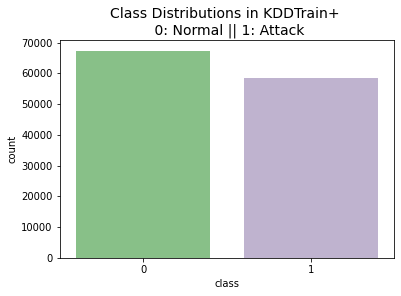

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.countplot(x="class", data=newdf, palette="Accent")
plt.title('Class Distributions in KDDTrain+ \n 0: Normal || 1: Attack', fontsize=14)
plt.show()

In [ ]:
newdf_test.groupby('class').count()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,Protocol_type_icmp,...,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,service_http_8001,service_aol,service_red_i,service_harvest,service_urh_i,service_http_2784
class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,...,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711
1,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,...,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833


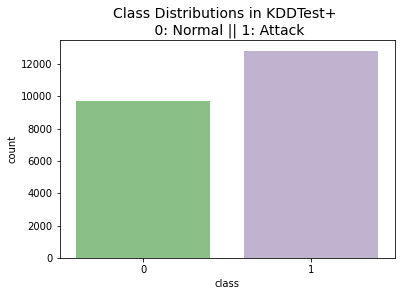

In [ ]:
sns.countplot(x="class", data=newdf_test, palette="Accent")
plt.title('Class Distributions in KDDTest+ \n 0: Normal || 1: Attack', fontsize=14)
plt.show()

**Feature Scaling**

In [ ]:
# step1: apply the logarithmic scaling method for scaling to obtain the ranges of `duration[0,4.77]', `src_bytes[0,9.11]' and `dst_bytes[0,9.11]
newdf['log2_value1'] = np.log2(newdf['duration'])
newdf['log2_value2'] = np.log2(newdf['src_bytes'])
newdf['log2_value3'] = np.log2(newdf['dst_bytes'])
newdf=newdf.drop(['log2_value3','log2_value2','log2_value1'], axis=1)


# testing set

newdf_test['log2_value1'] = np.log2(newdf_test['duration'])
newdf_test['log2_value2'] = np.log2(newdf_test['src_bytes'])
newdf_test['log2_value3'] = np.log2(newdf_test['dst_bytes'])
newdf_test=newdf_test.drop(['log2_value3','log2_value2','log2_value1'], axis=1)

print(newdf)
print(newdf_test)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


        duration  src_bytes  dst_bytes  land  ...  flag_S3  flag_SF  flag_SH  class
0              0        491          0     0  ...      0.0      1.0      0.0      0
1              0        146          0     0  ...      0.0      1.0      0.0      0
2              0          0          0     0  ...      0.0      0.0      0.0      1
3              0        232       8153     0  ...      0.0      1.0      0.0      0
4              0        199        420     0  ...      0.0      1.0      0.0      0
...          ...        ...        ...   ...  ...      ...      ...      ...    ...
125968         0          0          0     0  ...      0.0      0.0      0.0      1
125969         8        105        145     0  ...      0.0      1.0      0.0      0
125970         0       2231        384     0  ...      0.0      1.0      0.0      0
125971         0          0          0     0  ...      0.0      0.0      0.0      1
125972         0        151          0     0  ...      0.0      1.0      0.0

**Split the training set and testing set**

In [ ]:
x=newdf.drop('class',1) #X-train
y=newdf["class"] #y-Train
xtest=newdf_test.drop("class",1) #X-test
ytest=newdf_test['class'] # y-test
xtest

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,Protocol_type_icmp,...,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,service_http_8001,service_aol,service_red_i,service_harvest,service_urh_i,service_http_2784
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0
2,2,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0
3,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,2,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0
4,1,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,794,333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,100,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0
22540,0,317,938,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,11,0.0,0.00,0.0,0.0,1.00,0.00,0.18,197,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0
22541,0,54540,8314,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,5,10,0.0,0.00,0.0,0.0,1.00,0.00,0.20,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0
22542,0,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6,0.0,0.00,0.0,0.0,1.00,0.00,0.33,255,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
# Step 2: the value of every feature is mapped to the [0,1] range linearly
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
# Training Set
scale = MinMaxScaler()
scale= preprocessing.StandardScaler().fit(x)
x=scale.transform(x) 
scaletest= preprocessing.StandardScaler().fit(xtest)
xtest=scaletest.transform(xtest)

# **RNN-LSTM Model**

**Input layer**

LSTM input layer must be 3D
the meaning of the 3 input dimensions are: samples, time steps, and features.
The number of samples is assumed to be 1 or more.
reshape() function takes a tuple as an argument that defines the new shape.
number_of_rows_to_process_each_loop, the_time_interval_for_next_move(e.g. per day, per month), column

In [ ]:
from tensorflow import keras
import numpy as np
import datetime
import time
x=pd.DataFrame(x)
x = x.values
sample = x.shape[0]
features = x.shape[1]
#Train: convert 2D to 3D for input RNN
x_train = np.reshape(x,(sample,features,1)) #shape  = (125973, 18, 1)
#Test: convert 2D to 3D for input RNN
x_test=pd.DataFrame(xtest)
x_test = x_test.values
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

**Following the research paper**

Number of neuron in the hidden layer=123

The activation function in the hidden layer is sigmoid, in the output layer is softmax function.

In [ ]:
Model = keras.Sequential([

        keras.layers.LSTM(123,input_shape=(features,x_train.shape[2]),
                          activation='sigmoid',recurrent_activation='hard_sigmoid'),
        keras.layers.Dense(1,activation="softmax")
    ])

Model.compile(optimizer='rmsprop',loss='mse', metrics=['accuracy'])

#Training the model

Model.fit(x_train, y, epochs=10, batch_size= 32) 
Model.summary()

# Final evaluation of the model
scores = Model.evaluate(x_test, ytest, verbose=0)
print('/n')
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
3937/3937 [==============================] - 633s 160ms/step - loss: 0.5346 - accuracy: 0.4654
Epoch 2/10
3937/3937 [==============================] - 632s 161ms/step - loss: 0.5346 - accuracy: 0.4654
Epoch 3/10
3937/3937 [==============================] - 627s 159ms/step - loss: 0.5346 - accuracy: 0.4654
Epoch 4/10
3937/3937 [==============================] - 624s 158ms/step - loss: 0.5346 - accuracy: 0.4654
Epoch 5/10
3937/3937 [==============================] - 620s 158ms/step - loss: 0.5346 - accuracy: 0.4654
Epoch 6/10
3937/3937 [==============================] - 619s 157ms/step - loss: 0.5346 - accuracy: 0.4654
Epoch 7/10
3937/3937 [==============================] - 621s 158ms/step - loss: 0.5346 - accuracy: 0.4654
Epoch 8/10
3937/3937 [==============================] - 626s 159ms/step - loss: 0.5346 - accuracy: 0.4654
Epoch 9/10
3937/3937 [==============================] - 630s 160ms/step - loss: 0.5346 - accuracy: 0.4654
Epoch 10/10
3937/3937 [=======================

**To modify the results:**

number of neurons in the hidden layer is 80 neurons

Activation function: I used the hard_sigmoid in the hidden layer
and tanh in the output layer

In [ ]:
# Using tanh and sigmoid as activation functions

Model = keras.Sequential([

        keras.layers.LSTM(80,input_shape=(features,x_train.shape[2]),
                          activation='tanh',recurrent_activation='hard_sigmoid'),
        keras.layers.Dense(1,activation="tanh")
    ])

Model.compile(optimizer='rmsprop',loss='mse', metrics=['accuracy'])

#Training the model
Model.fit(x_train, y, epochs=10, batch_size= 32) 
Model.summary()

# Final evaluation of the model
scores = Model.evaluate(x_test, ytest, verbose=0)
print("/n")
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
3937/3937 [==============================] - 477s 121ms/step - loss: 0.0444 - accuracy: 0.9465
Epoch 2/10
3937/3937 [==============================] - 473s 120ms/step - loss: 0.0104 - accuracy: 0.9880
Epoch 3/10
3937/3937 [==============================] - 478s 121ms/step - loss: 0.0066 - accuracy: 0.9925
Epoch 4/10
3937/3937 [==============================] - 475s 121ms/step - loss: 0.0065 - accuracy: 0.9926
Epoch 5/10
3937/3937 [==============================] - 477s 121ms/step - loss: 0.0038 - accuracy: 0.9958
Epoch 6/10
3937/3937 [==============================] - 474s 120ms/step - loss: 0.0044 - accuracy: 0.9951
Epoch 7/10
3937/3937 [==============================] - 480s 122ms/step - loss: 0.0046 - accuracy: 0.9949
Epoch 8/10
3937/3937 [==============================] - 484s 123ms/step - loss: 0.0028 - accuracy: 0.9969
Epoch 9/10
3937/3937 [==============================] - 477s 121ms/step - loss: 0.0022 - accuracy: 0.9976
Epoch 10/10
3937/3937 [=======================

In [ ]:
ab = pd.DataFrame(ytest)

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 0,
                       ):
  print(ab)
#display(ab.to_markdown())

       class
0          1
1          1
2          0
3          1
4          1
5          0
6          0
7          1
8          0
9          1
10         1
11         0
12         1
13         1
14         0
15         0
16         0
17         0
18         0
19         1
20         1
21         1
22         0
23         0
24         1
25         1
26         0
27         0
28         1
29         0
30         1
31         0
32         0
33         0
34         1
35         1
36         0
37         1
38         0
39         0
40         1
41         0
42         0
43         0
44         1
45         0
46         1
47         1
48         1
49         0
50         0
51         0
52         1
53         1
54         1
55         0
56         1
57         1
58         1
59         0
60         1
61         1
62         0
63         0
64         1
65         0
66         1
67         1
68         1
69         0
70         1
71         0
72         0
73         0
74         1
75         0

In [ ]:
predictions = Model.predict(x_test[2:3])
predictions

array([[0.00533576]], dtype=float32)

In [ ]:
scores1 = Model.evaluate(x_test[0:100], ytest[0:100], verbose=0)
print("/n")
print("Accuracy: %.2f%%" % (scores1[1]*100))

/n
Accuracy: 92.00%
